# Alana Viana
# Tarefa Análise de Votos

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import numpy as np
from scipy import stats
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

%config InlineBackend.figure_format = 'retina' # set 'png' here when working on notebook
%matplotlib inline

In [2]:
df = pd.read_csv("data/eleicoes_2006_a_2010.csv")
train = df[(df["ano"]==2006)]
train = train.drop(columns=["ano"])
train = train.drop(columns=["sequencial_candidato"])
train = train.drop(columns=["nome"])

test = df[(df["ano"]==2010)]
test = test.drop(columns=["ano"])
test = test.drop(columns=["sequencial_candidato"])
test = test.drop(columns=["nome"])

all_data = pd.concat([train, test])

## Pré-Processamento

(tratamento de valores ausentes, variáveis categóricas e normalização, quando for o caso).

#### Normalização ( por enquanto não será utilizada )

array([[<AxesSubplot:title={'center':'votoss'}>,
        <AxesSubplot:title={'center':'log(price + 1)'}>]], dtype=object)

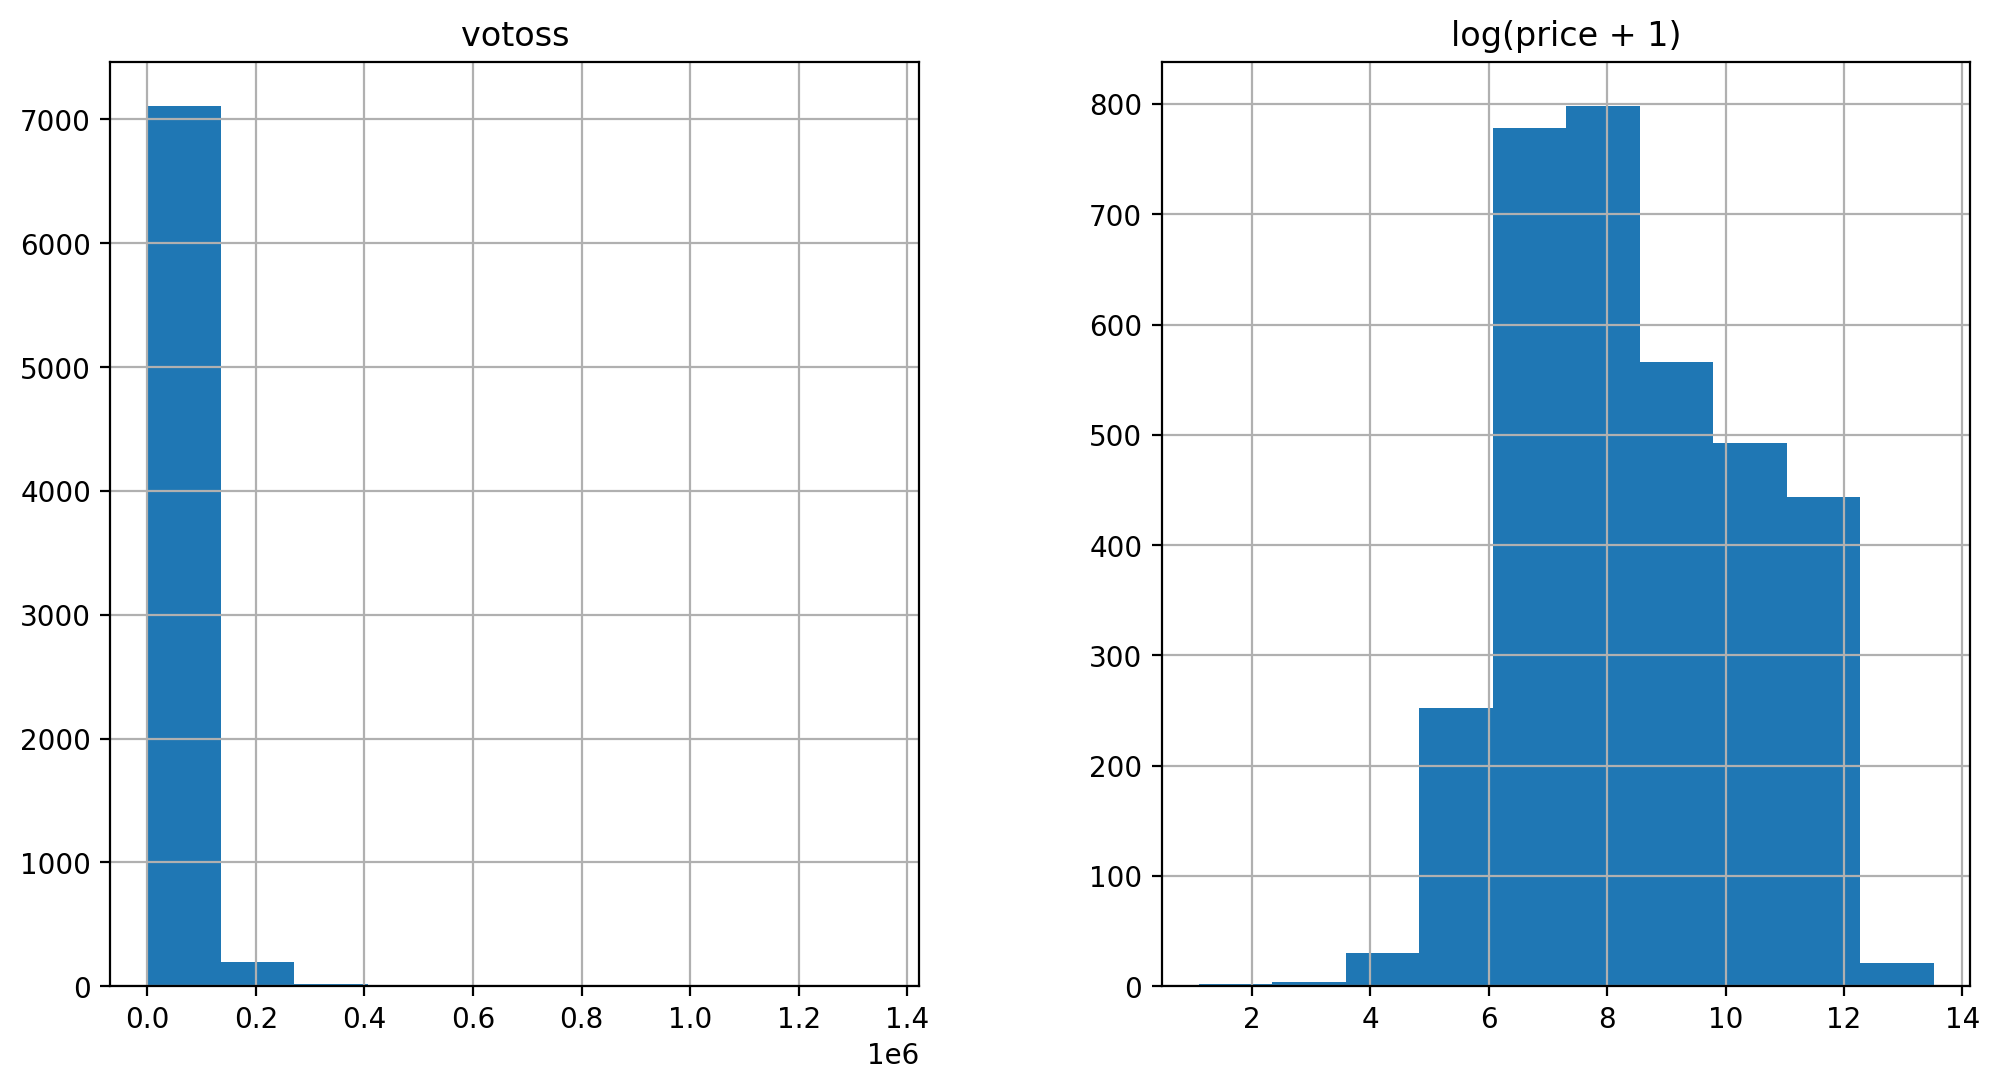

In [3]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"votoss":all_data["votos"], "log(price + 1)":np.log1p(train["votos"])})
prices.hist()

In [4]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())) # compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

#### Dummies e NA

In [5]:
all_data = pd.get_dummies(all_data) # dummies
all_data = all_data.fillna(all_data.mean()) # valores ausentes

###  Variáveis e métodos auxiliares

In [6]:
X_train = all_data[:train.shape[0]]
y_train = X_train["votos"]
X_train = X_train.drop(columns=["votos"])

In [7]:
X_test = all_data[train.shape[0]:]
y_test = X_test["votos"]
X_test = X_test.drop(columns=["votos"])

In [8]:
# encode knn
# label_encoder = preprocessing.LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)

In [9]:
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv = 5 ))
    return (rmse)

In [10]:
# def rmse_cv_knn(model):
#    rmse = np.sqrt(-cross_val_score(model, X_train, y_train_encoded, scoring = "neg_mean_squared_error", cv = 5 ))
#    return (rmse)

## Machine Learning

### Ridge Model

In [11]:
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 60, 65] # The higher the regularization the less prone our model will be to overfit
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)

Text(0, 0.5, 'rmse')

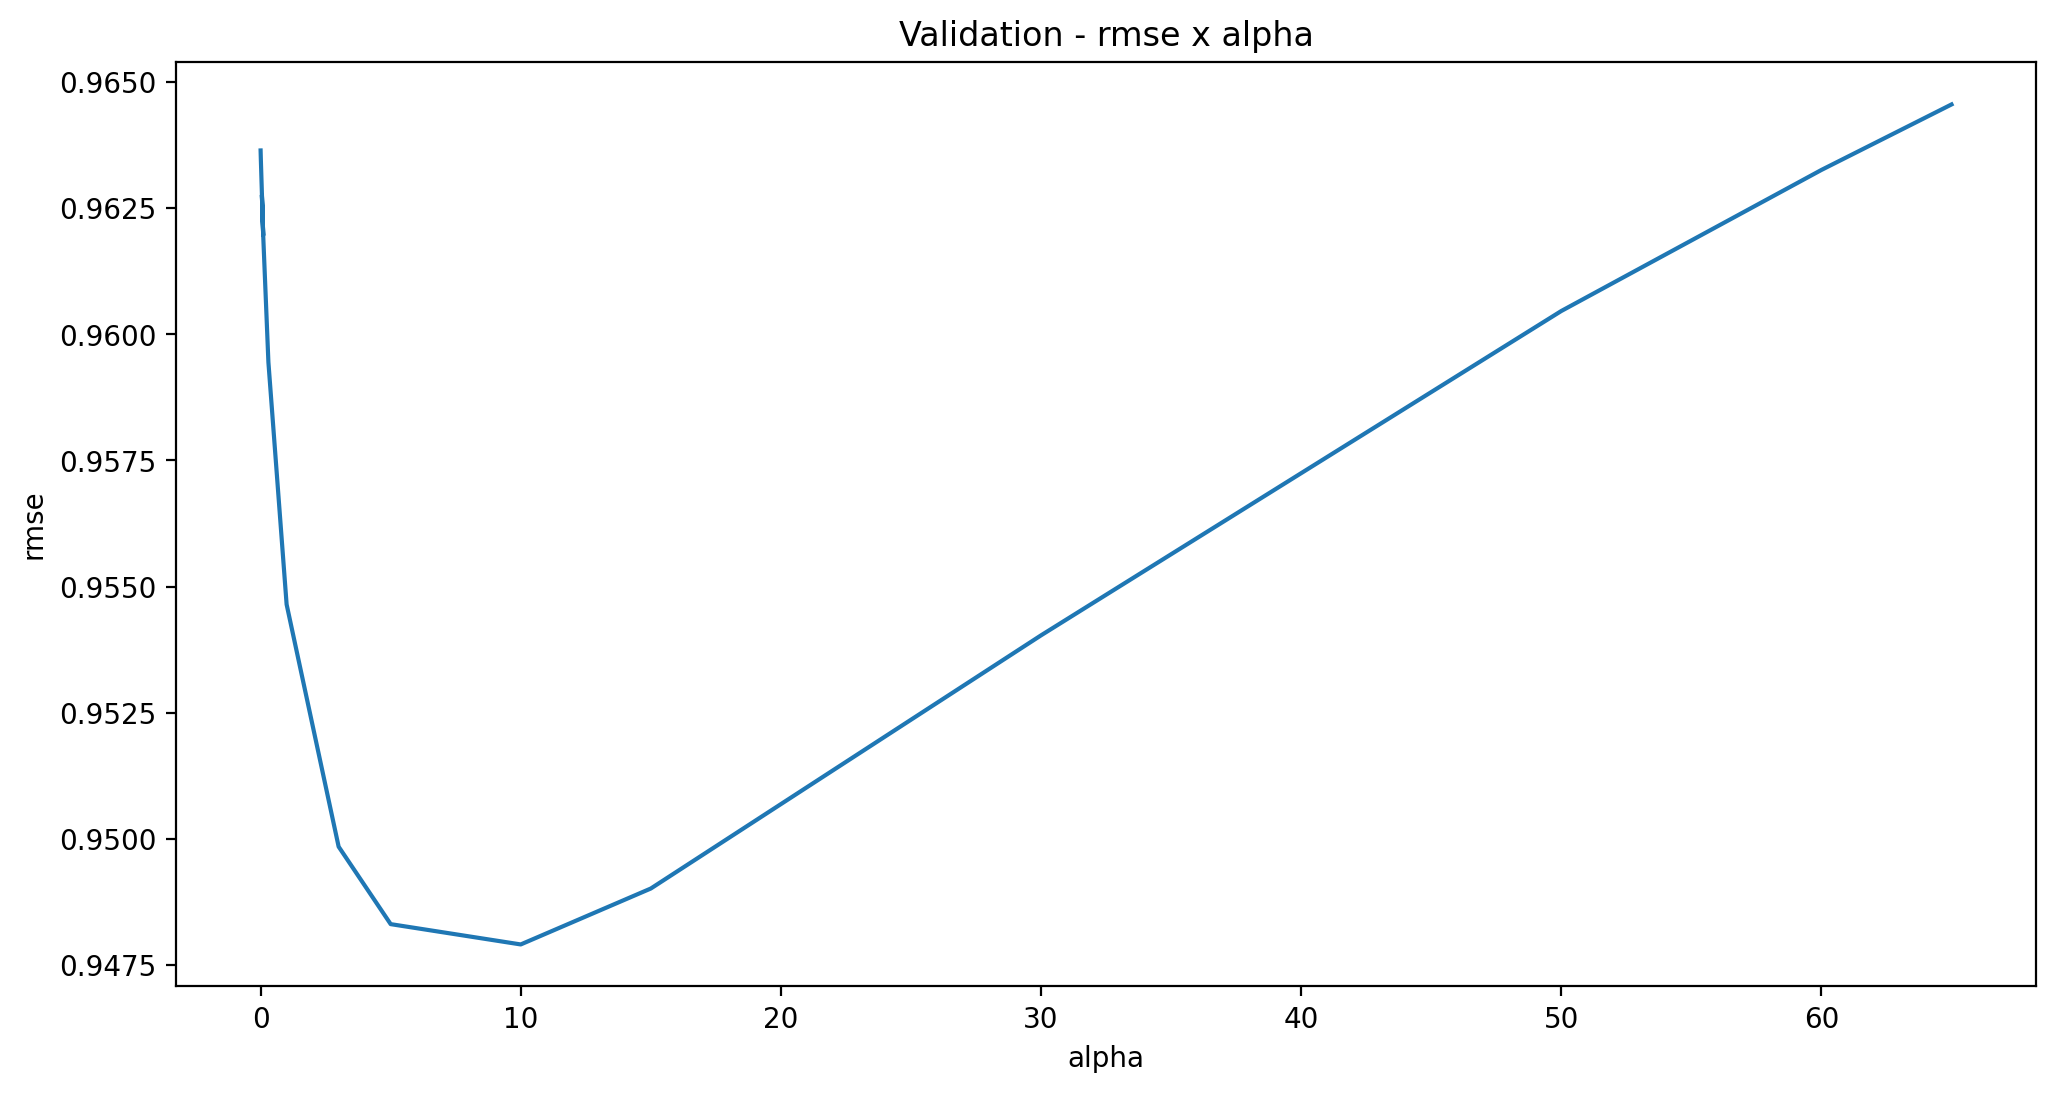

In [12]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - rmse x alpha")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [13]:
print("rmse Ridge: {}".format(cv_ridge.min()))

rmse Ridge: 0.9479115249847101


In [14]:
# alpha com o menor rmse
cv_ridge.index[[cv_ridge.values == cv_ridge.min()]]

c:\users\gisel\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexes\base.py:4616: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


Float64Index([10.0], dtype='float64')

In [15]:
model_ridge = Ridge(alpha=10)
model_ridge.fit(X_train, y_train)

Ridge(alpha=10)

In [37]:
y_pred_ridge = model_ridge.predict(X_test)

In [55]:
model_ridge.score(X_train, y_train)
print("Ridge - Coefficient of determination(R^2) no treino: {}".format(model_ridge.score(X_train, y_train)))

Ridge - Coefficient of determination(R^2) no treino: 0.7810618868437469


In [56]:
model_ridge.score(X_test, y_test)
print("Ridge - Coefficient of determination(R^2) no teste: {}".format(model_ridge.score(X_train, y_train)))

Ridge - Coefficient of determination(R^2) no teste: 0.7810618868437469


In [57]:
rmse = -cross_val_score(model_ridge, X_train, y_train, scoring = "neg_mean_squared_error", cv = 5 )
print("Ridge - Coefficient of determination - Cross validation - no treino: {} ".format(rmse.mean()))

Ridge - Coefficient of determination - Cross validation - no treino: 0.8986704150078968 


In [58]:
rmse = -cross_val_score(model_ridge, X_test, y_test, scoring = "neg_mean_squared_error", cv = 5 )
print("Ridge - Coefficient of determination - Cross validation - no teste: {} ".format(rmse.mean()))

Ridge - Coefficient of determination - Cross validation - no teste: 1.0636430434697508 


#### Ridge Coeficientes 

In [60]:
coef_ridge = pd.Series(model_ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coef_ridge != 0)) + " variables and eliminated the other " +  str(sum(coef_ridge == 0)) + " variables")

Ridge picked 227 variables and eliminated the other 33 variables


Text(0.5, 1.0, 'Coefficients in the Ridge Model')

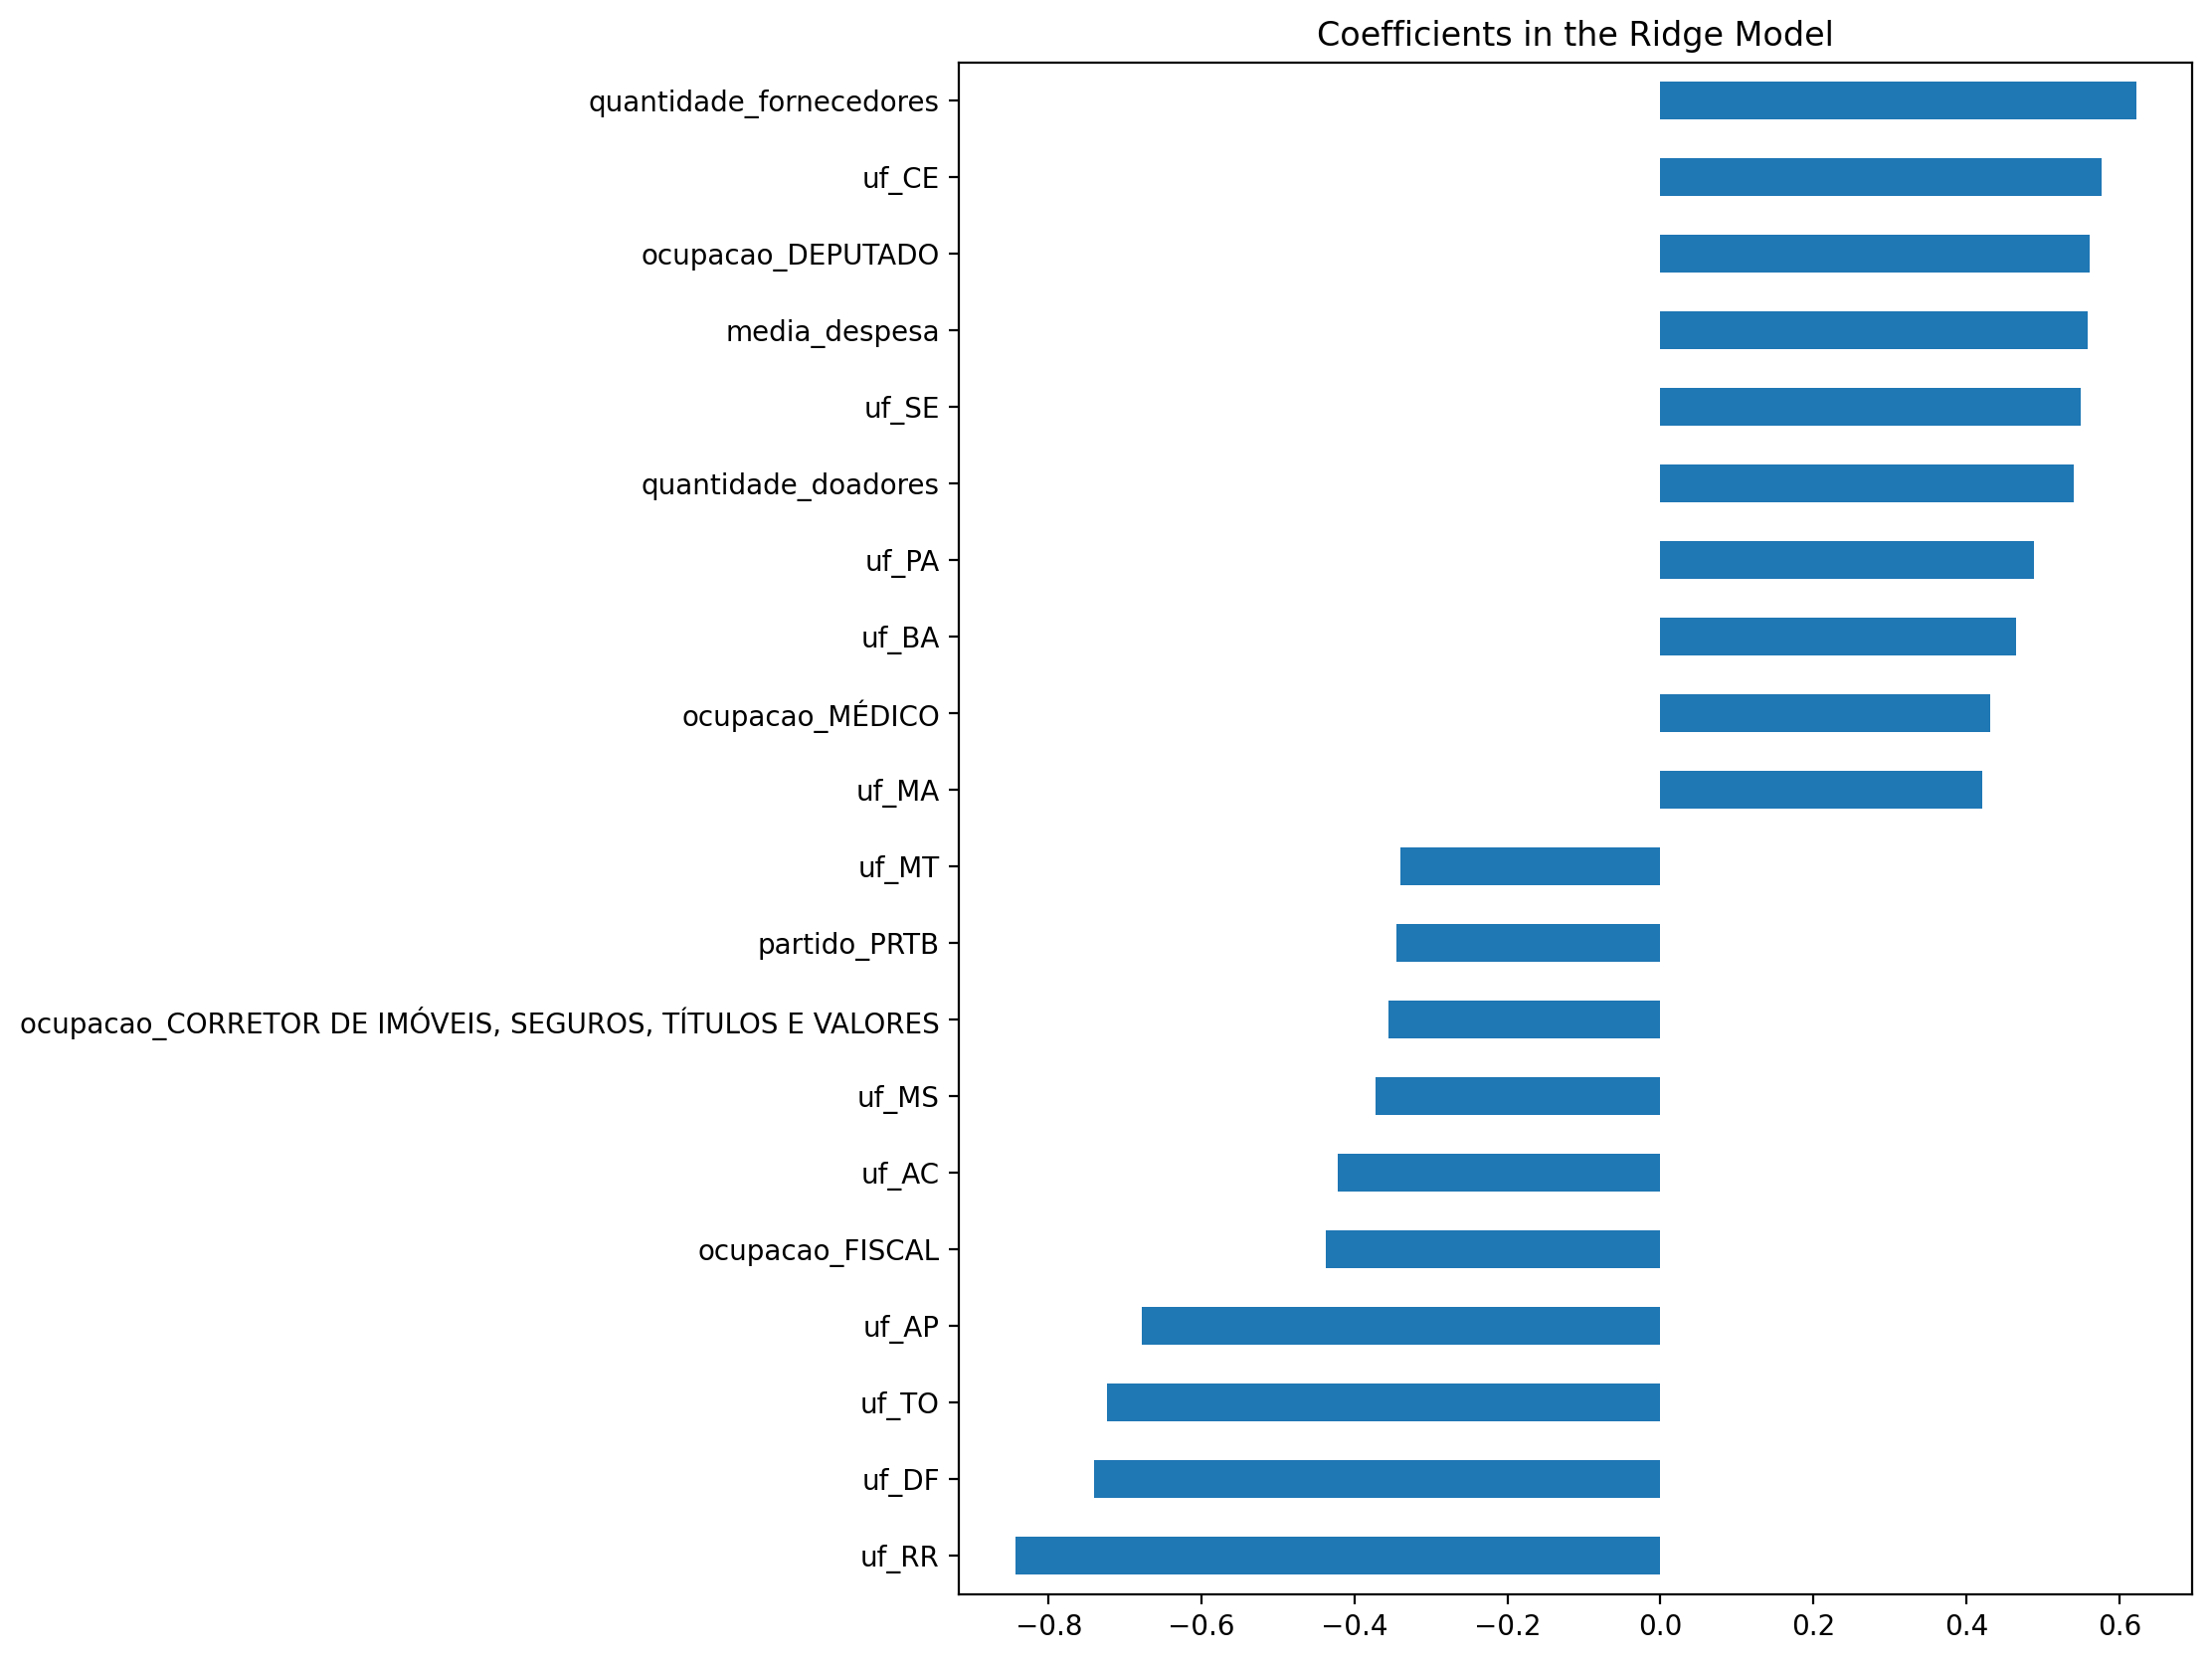

In [59]:
imp_coef_ridge = pd.concat([coef_ridge.sort_values().head(10),
                     coef_ridge.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef_ridge.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

In [ ]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_ridge.predict(X_train), "true": y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter")

### Lassso Model

In [ ]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], max_iter=60000000).fit(X_train, y_train)

In [ ]:
print("rmse Lasso: {}".format(rmse_cv(model_lasso).mean()))

In [ ]:
coef_lasso = pd.Series(model_lasso.coef_, index = X_train.columns)

In [ ]:
print("Ridge picked " + str(sum(coef_lasso != 0)) + " variables and eliminated the other " + str(sum(coef_lasso == 0)) + " variables")

In [ ]:
imp_coef_lasso = pd.concat([coef_lasso.sort_values().head(10), coef_lasso.sort_values().tail(10)])

In [ ]:
matplotlib.rcParams['figure.figsize'] = (6.0, 8.0)
imp_coef_lasso.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

In [ ]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true": y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter")

### SVR Model

In [ ]:
model_svr = svm.SVR(kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
model_svr.fit(X_train, y_train)
rmse = -cross_val_score(model_svr, X_train, y_train, scoring = "neg_mean_squared_error", cv = 5 )
rmse.mean()

In [ ]:
model_svr = svm.SVR(kernel='rbf')
model_svr.fit(X_train, y_train)
rmse = -cross_val_score(model_svr, X_train, y_train, scoring = "neg_mean_squared_error", cv = 5 )
rmse.mean()

In [ ]:
print("rmsr SVR Model: {}".format(rmse_cv(model_svr).mean()))

In [ ]:
y_pred_svr = model_svr.predict(X_test)

In [ ]:
print("acurácia SVR Model: {}".format(accuracy_score(y_test.to_numpy(), y_pred_svr.astype('int64'))))

Dica: No SVR o parâmetro C é um trade off (escolha) entre a incorreta classificação de exemplos de treinamento contra a simplicidade da superfície de decisão. Um C baixo torna a superfície de decisão suave, enquanto um C alto visa classificar todos os exemplos de treinamento corretamente, dando ao modelo liberdade para selecionar mais amostras como vetores de suporte. O parâmetro gamma define qual é a influência de um único exemplo de treinamento. É um coeficiente de kernel para 'rbf', 'poli' e 'sigmóide'. Se gamma for definido como 'auto' então 1/n_features serão usados. Valores baixos significam 'alta variância' e maior influência do vetor de suporte e valores altos significam 'baixa variância' e os vetores de suporte não possuem grande influência no processo de classificação. Os parâmetros gama podem ser vistos como o inverso do raio de influência de amostras selecionadas pelo modelo como vetores de suporte.

In [ ]:
def testar_kernels(kernels):
    for kernel in kernels:
        classifier = svm.SVR(kernel=kernel)
        cv_svr = rmse_cv(classifier).mean()
        cv_svr
        #cv_svr = pd.Series(cv_svr, index = alphas)
        #print("rmse SVR: {}".format(cv_svr.min()))
#['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
# o tempo de processamento do kernel linear é alto em relação aos demais
kernels = ['poly', 'rbf', 'sigmoid']
testar_kernels(kernels)

In [ ]:
rmse_cv(model_svr).mean()

In [ ]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_svr.predict(X_train), "true": y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter")

### RandomForestRegressor Model

In [ ]:
model_random = RandomForestRegressor(n_estimators = 50, random_state = 43, max_depth = 8)
model_random.fit(X_train, y_train)

In [ ]:
rmse = -cross_val_score(model_random, X_train, y_train, scoring = "neg_mean_squared_error", cv = 5 )
rmse.mean()

In [ ]:
print("rmse Random: {}".format(rmse_cv(model_random).mean()))

In [ ]:
y_pred_random = model_random.predict(X_test) 

In [ ]:
accuracy_score(y_test.to_numpy(), y_pred_random.astype("int64"))

In [ ]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_random.predict(X_train), "true": y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter")

### KNN Model

In [ ]:
model_knn = KNeighborsClassifier(n_neighbors=5)  
model_knn.fit(X_train, y_train_encoded)  

In [ ]:
rmse = -cross_val_score(model_knn, X_train, y_train_encoded, scoring = "neg_mean_squared_error", cv = 5 )
rmse.mean()

In [ ]:
print("rmse Random: {}".format(rmse_cv_knn(model_knn).mean()))

In [ ]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_knn.predict(X_train), "true": y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter")

## Analise dos Resultados

Dentre os modelos avaliados, qual foi o que deu o melhor resultado nos dados de 2014 em termos de RMSE? Justifique bem sua resposta

Entre o RandomForest (rmse=0.02) SVR (rmse=0.32), o Ridge(0.91) e o Lasso(0.32), o melhor modelo foi o RandomForest pois ele tinha um RMSE menor.

## XGBOOST ( em construção )

In [ ]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds=100)

In [ ]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [ ]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1)
model_xgb.fit(X_train, y)

In [ ]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

In [ ]:
predictions = pd.DataFrame({"xgb": xgb_preds, "lasso":lasso_preds})
predictions = predictions[(np.abs(stats.zscore(predictions)) < 3).all(axis=1)]
predictions.plot(x= "xgb", y = "lasso", kind = "scatter")

In [ ]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [ ]:
solution = pd.DataFrame({"nome":test.index, "votos":preds})
solution.to_csv("saida.csv", index = False)